<table style="border:none; border-collapse:collapse; cellspacing:0; cellpadding:0">
    <tr>
        <td width=30% style="border:none">
            <img src="logo_datascientest.png" width="100%"/>
        </td>
        <td style="border:none">
            <center>
                <h1>DS project: Customer satisfaction</h1>
                <h2>Modelisation - Transformers</h2>
            </center>
        </td>
    </tr>
</table>

<hr>

**Date** : 2023

**Author** : Elie MAZE, Luc Thomas

**Goal** : Train & evaluate models

In [128]:
import _mypath
import os
import shap
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from tqdm import tqdm
from threadpoolctl import threadpool_limits

import torch
from torch.utils.data import DataLoader
from transformers import FlaubertTokenizer, FlaubertForSequenceClassification, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from random import choice

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from visu.visu import plotCMX, plotErrors, plot_learning_curves
from utils.utils import getErrors
from training.dataset import CommentDataset
from explicability.explicability import explain

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
DATA_FOLDER = "/data/DATALAB_PAU/20_projects/j0215602/DS_NLP/input/labeled"
MODEL_PATH = "/data/DATALAB_PAU/07_Models/transformers/pretrained/flaubert-base-uncased"
MODEL_OUTFILE = "/data/DATALAB_PAU/07_Models/transformers/test/flaubert-base-uncased"
MODEL_OUTFILE_5CLS = "/data/DATALAB_PAU/07_Models/transformers/test/flaubert-base-uncased-5cls"
_MAX_WORKERS = 8

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="14"
os.environ["LD_LIBRARY_PATH"]="/data/appli_PITSI/HGX2//nvidia/cuda/install/cuda_11.2.1/lib64/:/data/appli_PITSI/HGX2/nvidia/cuda/install/cuda_11.2.1_compat/lib64:/data/appli_PITSI/HGX2/nvidia/cudnn/install/cudnn-11.2-linux-x64-v8.1.1.33/lib64"

In [6]:
# selecting a GPU with PyTorch (choose a free GPU!) 
GPU_NUMBER=0

# setting device on GPU if available, else CPU
device = torch.device("cuda:{0}".format(GPU_NUMBER) if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print("__Used Logical Devices: {0}".format(device))
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("__Device Name:",torch.cuda.get_device_name(GPU_NUMBER))
    print("__Device Total Memory: {} GB".format(round(torch.cuda.get_device_properties(device).total_memory/1024**3,1)))
    print("__Memory Usage: Allocated {0} GB, Cached {1} GB".format(
        round(torch.cuda.memory_allocated(device)/1024**3,1), 
        round(torch.torch.cuda.memory_reserved(device)/1024**3,1)))

__Used Logical Devices: cuda:0
__CUDNN VERSION: 8101
__Device Name: Tesla V100-SXM3-32GB
__Device Total Memory: 31.7 GB
__Memory Usage: Allocated 0.0 GB, Cached 0.0 GB


# __FlauBERT__

In [9]:
num_classes = 2
batch_size = 32
num_epochs = 8
learning_rate = 2e-5

# 2 classes
## Data loading

In [6]:
DATA_FOLDER = r"D:\DevPy\DS_NLP\input\labeled"
MODEL_PATH = r"D:\DevPy\DS_NLP\models\flaubert-base-uncased"
MODEL_OUTFILE = r"D:\DevPy\DS_NLP\models\fine_tuned\flaubert-base-uncased"

In [7]:
outfile_2cls_train = os.path.join(DATA_FOLDER, "train_2classes.csv")
df_train = pd.read_csv(outfile_2cls_train, sep=",", encoding="utf-8", engine="python")

outfile_2cls_val = os.path.join(DATA_FOLDER, "val_2classes.csv")
df_val = pd.read_csv(outfile_2cls_val, sep=",", encoding="utf-8", engine="python")

outfile_2cls_test = os.path.join(DATA_FOLDER, "test_2classes.csv")
df_test = pd.read_csv(outfile_2cls_test, sep=",", encoding="utf-8", engine="python")

print("train set:", df_train.shape)
print("val set:", df_val.shape)
print("test set:", df_test.shape)

train set: (63459, 11)
val set: (15865, 11)
test set: (19832, 11)


# Load pretrained models

In [10]:
tokenizer = FlaubertTokenizer.from_pretrained(MODEL_PATH)

In [11]:
model = FlaubertForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=num_classes).to(device)

Some weights of the model checkpoint at /data/DATALAB_PAU/07_Models/transformers/pretrained/flaubert-base-uncased were not used when initializing FlaubertForSequenceClassification: ['pred_layer.proj.weight', 'pred_layer.proj.bias']
- This IS expected if you are initializing FlaubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at /data/DATALAB_PAU/07_Models/transformers/pretrained/flaubert-base-uncased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight

In [12]:
if torch.cuda.is_available():
    print("__Used Logical Devices: {0}".format(device))
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("__Device Name:",torch.cuda.get_device_name(GPU_NUMBER))
    print("__Device Total Memory: {} GB".format(round(torch.cuda.get_device_properties(device).total_memory/1024**3,1)))
    print("__Memory Usage: Allocated {0} GB, Cached {1} GB".format(
        round(torch.cuda.memory_allocated(device)/1024**3,1), 
        round(torch.torch.cuda.memory_reserved(device)/1024**3,1)))

__Used Logical Devices: cuda:0
__CUDNN VERSION: 8101
__Device Name: Tesla V100-SXM3-32GB
__Device Total Memory: 31.7 GB
__Memory Usage: Allocated 0.5 GB, Cached 0.5 GB


## Data prep
### Encode labels

In [72]:
mapping = {1:0, 2:0, 
           4:1, 5:1}

df_train["Sentiment_code"] = df_train["star"].replace(mapping).astype(int)
df_val["Sentiment_code"] = df_val["star"].replace(mapping).astype(int)
df_test["Sentiment_code"] = df_test["star"].replace(mapping).astype(int)

In [14]:
X_train = df_train["Commentaire"].values
y_train = df_train["Sentiment_code"].values

train_dataset = CommentDataset(X_train, y_train, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [15]:
first_batch = next(iter(train_loader))

print(first_batch["input_ids"].shape)
print(first_batch["attention_mask"].shape)
print(first_batch["labels"].shape)

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


In [16]:
first_batch["labels"].unique()

tensor([0, 1])

In [17]:
train_dataset = CommentDataset(X_train, y_train, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X_val = df_val["Commentaire"].values
y_val = df_val["Sentiment_code"].values

val_dataset = CommentDataset(X_val, y_val, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [73]:
X_test = df_test["Commentaire"].values
y_test = df_test["Sentiment_code"].values

test_dataset = CommentDataset(X_test, y_test, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Training

In [78]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


In [20]:
hist_train_loss = []
hist_val_loss = []
hist_train_acc = []
hist_val_acc = []
min_loss = float('inf')
best_model = None

with threadpool_limits(limits=_MAX_WORKERS):

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        train_accuracy = total_correct / total_samples

        hist_train_loss += [avg_loss]
        hist_train_acc += [train_accuracy]

        ## EVAL
        model.eval()
        valid_loss = 0
        valid_correct = 0
        valid_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                logits = outputs.logits
                loss = loss_fn(logits, labels)

                valid_loss += loss.item()
                _, predicted = torch.max(logits, 1)
                valid_correct += (predicted == labels).sum().item()
                valid_samples += labels.size(0)

        avg_valid_loss = valid_loss / len(val_loader)
        valid_accuracy = valid_correct / valid_samples

        print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_loss:.4f} , Accuracy: {train_accuracy:.4f} - Validation Loss: {avg_valid_loss:.4f} , Accuracy: {valid_accuracy:.4f}")

        if min_loss >= avg_valid_loss:
            min_loss = avg_valid_loss
            model.save_pretrained(MODEL_OUTFILE)

        scheduler.step(avg_valid_loss)

        hist_val_loss += [avg_valid_loss]
        hist_val_acc += [valid_accuracy]

100%|██████████| 1984/1984 [07:52<00:00,  4.20it/s]


Epoch 1/8 - Training Loss: 0.1158 , Accuracy: 0.9572 - Validation Loss: 0.0828 , Accuracy: 0.9695


100%|██████████| 1984/1984 [07:39<00:00,  4.32it/s]


Epoch 2/8 - Training Loss: 0.0789 , Accuracy: 0.9708 - Validation Loss: 0.0930 , Accuracy: 0.9667


100%|██████████| 1984/1984 [07:45<00:00,  4.26it/s]


Epoch 3/8 - Training Loss: 0.0631 , Accuracy: 0.9774 - Validation Loss: 0.0862 , Accuracy: 0.9714


100%|██████████| 1984/1984 [07:42<00:00,  4.29it/s]


Epoch 4/8 - Training Loss: 0.0495 , Accuracy: 0.9825 - Validation Loss: 0.0999 , Accuracy: 0.9694
Epoch 00004: reducing learning rate of group 0 to 2.0000e-06.


100%|██████████| 1984/1984 [07:39<00:00,  4.31it/s]


Epoch 5/8 - Training Loss: 0.0276 , Accuracy: 0.9910 - Validation Loss: 0.1049 , Accuracy: 0.9711


100%|██████████| 1984/1984 [07:41<00:00,  4.30it/s]


Epoch 6/8 - Training Loss: 0.0209 , Accuracy: 0.9935 - Validation Loss: 0.1227 , Accuracy: 0.9703


100%|██████████| 1984/1984 [07:40<00:00,  4.31it/s]


Epoch 7/8 - Training Loss: 0.0163 , Accuracy: 0.9954 - Validation Loss: 0.1259 , Accuracy: 0.9709
Epoch 00007: reducing learning rate of group 0 to 2.0000e-07.


100%|██████████| 1984/1984 [08:23<00:00,  3.94it/s]


Epoch 8/8 - Training Loss: 0.0135 , Accuracy: 0.9964 - Validation Loss: 0.1322 , Accuracy: 0.9708


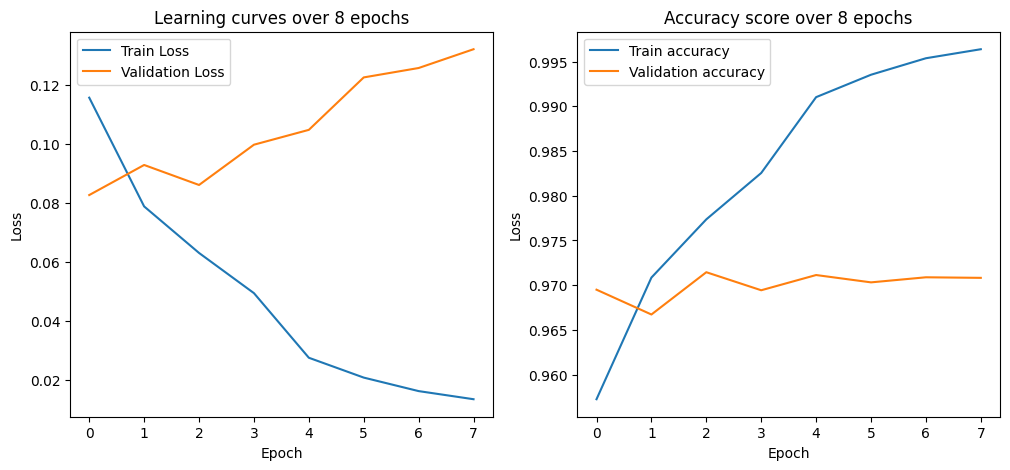

In [28]:
plot_learning_curves(num_epochs, hist_train_loss, hist_val_loss, hist_train_acc, hist_val_acc, figsize=(12, 5))

## Evaluation

In [76]:
model_finetuned = FlaubertForSequenceClassification.from_pretrained(MODEL_OUTFILE, num_labels=num_classes).to(device)

In [79]:
y_pred = []
y_true = []

model_finetuned.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model_finetuned(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        _, predicted = torch.max(logits, 1)
        predictions = predicted.cpu().numpy()
        labels = labels.cpu().numpy()

        y_pred.extend(predictions)
        y_true.extend(labels)
        

y_pred = np.array(y_pred)
y_true = np.array(y_true)

Labels: [0, 2]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


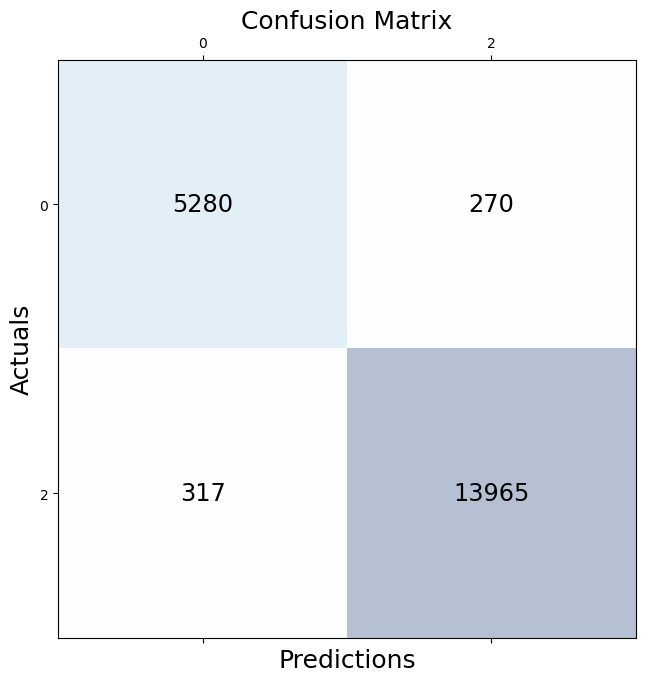

In [80]:
LABELS = [0,2]
print("Labels:", LABELS)

cm = confusion_matrix(y_true, y_pred)
plotCMX(LABELS, cm)

In [81]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5550
           1       0.98      0.98      0.98     14282

    accuracy                           0.97     19832
   macro avg       0.96      0.96      0.96     19832
weighted avg       0.97      0.97      0.97     19832



## Explicability

Les attributions sont des scores ou des poids qui indiquent l'importance relative de chaque subword de la séquence d'entrée pour la prédiction finale du modèle.  
Pour calculer ces attributions, Captum effectue une comparaison entre les entrées réelles (input_ids) et une ligne de base (baseline_input_ids) pour chaque élément de la séquence.  
La ligne de base (baseline) est une séquence fictive qui sert de référence pour évaluer l'importance des éléments de la séquence d'entrée. Elle est construite avec des valeurs neutres ou par défaut, ici: pad_token_id.

In [123]:
tokenizer = FlaubertTokenizer.from_pretrained(MODEL_PATH)

In [96]:
model = FlaubertForSequenceClassification.from_pretrained(MODEL_OUTFILE, num_labels=num_classes).to("cpu")

Primary attribution: a method to evaluate the influence of each feature on the model’s prediction

In [106]:
index = choice(range(0, df_test.shape[0]-1))
text = df_test.at[index, "Commentaire"]
prediction = y_pred[index]
true_class = y_true[index]

print("index:", index)
print("- True value:", true_class)
print("- Prediction:", prediction, end="\n\n")

print(text)

index: 7313
- True value: 1
- Prediction: 1

parfait toujours très honnête et professionnelle


In [129]:
mapping_classes = {0: "NEGATIVE", 1: "POSITIVE"}
explain(model, tokenizer, text, true_class, mapping_classes)


CLASS: NEGATIVE



True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (3.62),parfait toujours très honnête et professionnelle,-0.06,#/s parfait toujours très honnête et professionnelle #/s



CLASS: POSITIVE



True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (3.62),parfait toujours très honnête et professionnelle,-0.73,#/s parfait toujours très honnête et professionnelle #/s


# 5 classes
## Data loading

In [60]:
num_classes = 5

In [59]:
outfile_5cls_train = os.path.join(DATA_FOLDER, "train_5classes.csv")
df_train = pd.read_csv(outfile_5cls_train, sep=",", encoding="utf-8", engine="python")

outfile_5cls_val = os.path.join(DATA_FOLDER, "val_5classes.csv")
df_val = pd.read_csv(outfile_5cls_val, sep=",", encoding="utf-8", engine="python")

outfile_5cls_test = os.path.join(DATA_FOLDER, "test_5classes.csv")
df_test = pd.read_csv(outfile_5cls_test, sep=",", encoding="utf-8", engine="python")

print("train set:", df_train.shape)
print("val set:", df_val.shape)
print("test set:", df_test.shape)

train set: (67525, 11)
val set: (16882, 11)
test set: (21104, 11)


# Load pretrained models

In [55]:
tokenizer = FlaubertTokenizer.from_pretrained(MODEL_PATH)

In [56]:
model = FlaubertForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=num_classes).to(device)

Some weights of the model checkpoint at /data/DATALAB_PAU/07_Models/transformers/pretrained/flaubert-base-uncased were not used when initializing FlaubertForSequenceClassification: ['pred_layer.proj.weight', 'pred_layer.proj.bias']
- This IS expected if you are initializing FlaubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at /data/DATALAB_PAU/07_Models/transformers/pretrained/flaubert-base-uncased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight

In [57]:
if torch.cuda.is_available():
    print("__Used Logical Devices: {0}".format(device))
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("__Device Name:",torch.cuda.get_device_name(GPU_NUMBER))
    print("__Device Total Memory: {} GB".format(round(torch.cuda.get_device_properties(device).total_memory/1024**3,1)))
    print("__Memory Usage: Allocated {0} GB, Cached {1} GB".format(
        round(torch.cuda.memory_allocated(device)/1024**3,1), 
        round(torch.torch.cuda.memory_reserved(device)/1024**3,1)))

__Used Logical Devices: cuda:0
__CUDNN VERSION: 8101
__Device Name: Tesla V100-SXM3-32GB
__Device Total Memory: 31.7 GB
__Memory Usage: Allocated 3.2 GB, Cached 5.8 GB


## Data prep
### Encode labels

In [62]:
df_train["Sentiment_code"] = df_train["star"]-1
df_val["Sentiment_code"] = df_val["star"]-1
df_test["Sentiment_code"] = df_test["star"]-1

df_test["Sentiment_code"].value_counts().sort_index()

Sentiment_code
0     4828
1      722
2     1271
3     3684
4    10599
Name: count, dtype: int64

In [63]:
X_train = df_train["Commentaire"].values
y_train = df_train["Sentiment_code"].values

train_dataset = CommentDataset(X_train, y_train, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X_val = df_val["Commentaire"].values
y_val = df_val["Sentiment_code"].values

val_dataset = CommentDataset(X_val, y_val, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

X_test = df_test["Commentaire"].values
y_test = df_test["Sentiment_code"].values

test_dataset = CommentDataset(X_test, y_test, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Training

In [64]:
stats_class = df_train.star.value_counts().sort_index().to_dict()
stats_class = np.array(list(stats_class.values()))
class_weights = sum(stats_class) / (num_classes*stats_class)

print("Class weights for uibalanced dataset:")
for star in range(5):
    print(f"star {star:d}: {class_weights[star]:.4f}")

Class weights for uibalanced dataset:
star 0: 0.8742
star 1: 5.8514
star 2: 3.3206
star 3: 1.1458
star 4: 0.3982


In [65]:
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device)) 

In [66]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


In [67]:
hist_train_loss = []
hist_val_loss = []
hist_train_acc = []
hist_val_acc = []
min_loss = float('inf')
best_model = None

with threadpool_limits(limits=_MAX_WORKERS):

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        train_accuracy = total_correct / total_samples

        hist_train_loss += [avg_loss]
        hist_train_acc += [train_accuracy]

        ## EVAL
        model.eval()
        valid_loss = 0
        valid_correct = 0
        valid_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                logits = outputs.logits
                loss = loss_fn(logits, labels)

                valid_loss += loss.item()
                _, predicted = torch.max(logits, 1)
                valid_correct += (predicted == labels).sum().item()
                valid_samples += labels.size(0)

        avg_valid_loss = valid_loss / len(val_loader)
        valid_accuracy = valid_correct / valid_samples

        print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_loss:.4f} , Accuracy: {train_accuracy:.4f} - Validation Loss: {avg_valid_loss:.4f} , Accuracy: {valid_accuracy:.4f}")

        if min_loss >= avg_valid_loss:
            min_loss = avg_valid_loss
            model.save_pretrained(MODEL_OUTFILE_5CLS)

        scheduler.step(avg_valid_loss)

        hist_val_loss += [avg_valid_loss]
        hist_val_acc += [valid_accuracy]

100%|██████████| 2111/2111 [08:21<00:00,  4.21it/s]


Epoch 1/8 - Training Loss: 1.0643 , Accuracy: 0.6221 - Validation Loss: 0.7341 , Accuracy: 0.6874


100%|██████████| 2111/2111 [08:09<00:00,  4.31it/s]


Epoch 2/8 - Training Loss: 0.9263 , Accuracy: 0.6776 - Validation Loss: 0.7200 , Accuracy: 0.7049


100%|██████████| 2111/2111 [08:09<00:00,  4.31it/s]


Epoch 3/8 - Training Loss: 0.8821 , Accuracy: 0.6883 - Validation Loss: 0.7345 , Accuracy: 0.6970


100%|██████████| 2111/2111 [08:08<00:00,  4.32it/s]


Epoch 4/8 - Training Loss: 0.8268 , Accuracy: 0.6994 - Validation Loss: 0.7193 , Accuracy: 0.7088


100%|██████████| 2111/2111 [08:10<00:00,  4.30it/s]


Epoch 5/8 - Training Loss: 0.7707 , Accuracy: 0.7139 - Validation Loss: 0.7879 , Accuracy: 0.6805


100%|██████████| 2111/2111 [08:07<00:00,  4.33it/s]


Epoch 6/8 - Training Loss: 0.7012 , Accuracy: 0.7264 - Validation Loss: 0.7624 , Accuracy: 0.7000


100%|██████████| 2111/2111 [08:09<00:00,  4.31it/s]


Epoch 7/8 - Training Loss: 0.6367 , Accuracy: 0.7417 - Validation Loss: 0.7996 , Accuracy: 0.6920
Epoch 00007: reducing learning rate of group 0 to 2.0000e-06.


100%|██████████| 2111/2111 [08:11<00:00,  4.30it/s]


Epoch 8/8 - Training Loss: 0.4920 , Accuracy: 0.7745 - Validation Loss: 0.8612 , Accuracy: 0.6960


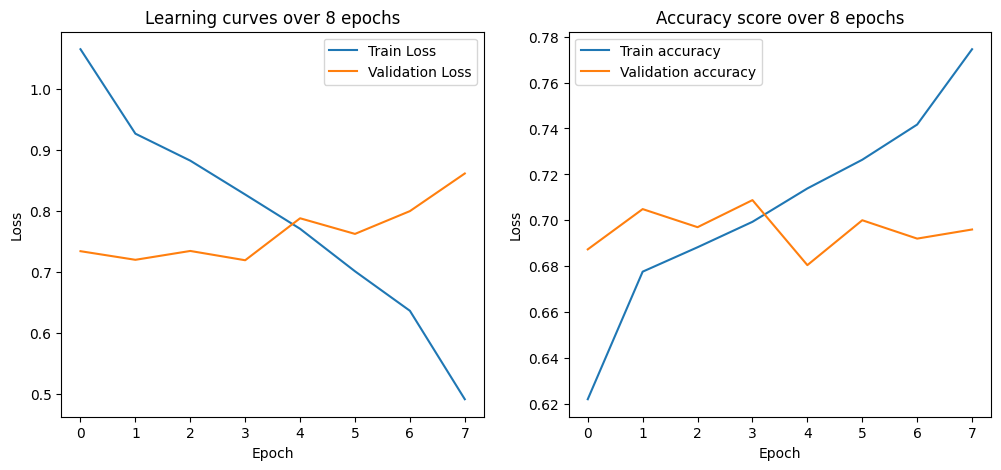

In [69]:
plot_learning_curves(num_epochs, hist_train_loss, hist_val_loss, hist_train_acc, hist_val_acc, figsize=(12, 5))

## Evaluation

In [70]:
model_finetuned = FlaubertForSequenceClassification.from_pretrained(MODEL_OUTFILE_5CLS, num_labels=num_classes).to(device)

In [71]:
y_pred = []
y_true = []

model_finetuned.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model_finetuned(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        _, predicted = torch.max(logits, 1)
        predictions = predicted.cpu().numpy()
        labels = labels.cpu().numpy()

        y_pred.extend(predictions)
        y_true.extend(labels)
        

y_pred = np.array(y_pred)
y_true = np.array(y_true)

Labels: [0, 1, 2, 3, 4]


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


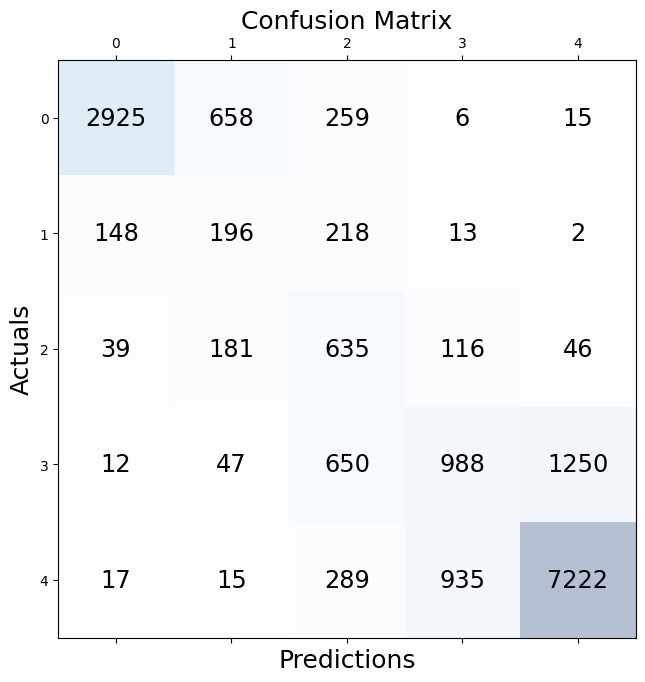

In [72]:
LABELS = [0, 1, 2, 3, 4]
print("Labels:", LABELS)

cm = confusion_matrix(y_true, y_pred)
plotCMX(LABELS, cm)

In [73]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84      3863
           1       0.18      0.34      0.23       577
           2       0.31      0.62      0.41      1017
           3       0.48      0.34      0.39      2947
           4       0.85      0.85      0.85      8478

    accuracy                           0.71     16882
   macro avg       0.55      0.58      0.55     16882
weighted avg       0.75      0.71      0.72     16882

